In [19]:
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
%matplotlib inline

# Load MNIST data
import mnist

In [20]:
def xavier_init(channel_in, channel_out, constant = 1): 
    """
    Xavier initialization of network weights
    """
    
    low = -constant * np.sqrt(6.0 / (channel_in + channel_out)) 
    high = constant * np.sqrt(6.0 / (channel_in + channel_out))
    return tf.random_uniform((channel_in, channel_out), minval = low, maxval = high, dtype=tf.float32)

### Define Model

In [21]:
class VAE(object):
    
    def __init__(self, network_architecture, learning_rate=0.001, batch_size=100):
        """
        Set up the VAE model.
        """
        
        # Set model parameters
        self.network_architecture = network_architecture
        self.lr = learning_rate
        self.batch_size = batch_size
        
        self.x = tf.placeholder(tf.float32, [None, network_architecture["n_input"]])
        
        # Forward pass
        self.forward()
        
        # Backward pass
        self.backward()

        # Initialize the variables and launch the session
        self.sess = tf.InteractiveSession()
        self.sess.run(tf.global_variables_initializer())
        
    def initialize_weights(self, n_hidden_enc_1, n_hidden_enc_2, 
                           n_hidden_dec_1, n_hidden_dec_2, n_input, n_z):
        """
        Initialize weights of the network layers.
        """
        
        network_weights = dict()
        network_weights['encoder_weights'] = {
            'W1': tf.Variable(xavier_init(n_input, n_hidden_enc_1)),
            'W2': tf.Variable(xavier_init(n_hidden_enc_1, n_hidden_enc_2)),
            'W_mu': tf.Variable(xavier_init(n_hidden_enc_2, n_z)),
            'W_logvar': tf.Variable(xavier_init(n_hidden_enc_2, n_z))}
        network_weights['encoder_bias'] = {
            'b1': tf.Variable(tf.zeros([n_hidden_enc_1], dtype=tf.float32)),
            'b2': tf.Variable(tf.zeros([n_hidden_enc_2], dtype=tf.float32)),
            'b_mu': tf.Variable(tf.zeros([n_z], dtype=tf.float32)),
            'b_logvar': tf.Variable(tf.zeros([n_z], dtype=tf.float32))}
        network_weights['decoder_weights'] = {
            'W1': tf.Variable(xavier_init(n_z, n_hidden_dec_1)),
            'W2': tf.Variable(xavier_init(n_hidden_dec_1, n_hidden_dec_2)),
            'W_out': tf.Variable(xavier_init(n_hidden_dec_2, n_input))}
        network_weights['decoder_bias'] = {
            'b1': tf.Variable(tf.zeros([n_hidden_dec_1], dtype=tf.float32)),
            'b2': tf.Variable(tf.zeros([n_hidden_dec_2], dtype=tf.float32)),
            'b_out': tf.Variable(tf.zeros([n_input], dtype=tf.float32))}
        return network_weights
 

    def encode(self, weights, bias):
        """
        Use the encoder model to map the input data to the latent space.
        """
        
        hidden_1 = tf.nn.relu(tf.add(tf.matmul(self.x, weights['W1']), bias['b1'])) 
        hidden_2 = tf.nn.relu(tf.add(tf.matmul(hidden_1, weights['W2']), bias['b2'])) 
        mu = tf.add(tf.matmul(hidden_2, weights['W_mu']), bias['b_mu'])
        logvar = tf.add(tf.matmul(hidden_2, weights['W_logvar']), bias['b_logvar'])
        return (mu, logvar)

    def decode(self, weights, bias):
        """
        Use the decoder model to reconstruct the input data.
        """
        
        hidden_1 = tf.nn.leaky_relu(tf.add(tf.matmul(self.z, weights['W1']), bias['b1'])) 
        hidden_2 = tf.nn.leaky_relu(tf.add(tf.matmul(hidden_1, weights['W2']), bias['b2'])) 
        recon_x = tf.nn.sigmoid(tf.add(tf.matmul(hidden_2, weights['W_out']), bias['b_out']))
        return recon_x
    
    
    def forward(self):
        """
        Build the VAE network.
        """
        
        # Initialize weights and bias
        network_weights = self.initialize_weights(**self.network_architecture)

        # Use encoder model to obtain latent z
        self.mu, self.logvar = self.encode(network_weights["encoder_weights"], 
                                      network_weights["encoder_bias"])

        # Draw sample z from Gaussian using reparametrization trick
        n_z = self.network_architecture["n_z"]
        eps = tf.random_normal((self.batch_size, n_z), 0, 1, dtype=tf.float32)
        self.z = tf.add(self.mu, tf.multiply(tf.sqrt(tf.exp(self.logvar)), eps))

        # Use decoder model to obtain the reconstructed input
        self.recon_x = self.decode(network_weights["decoder_weights"],
                                    network_weights["decoder_bias"])
            
            
    def backward(self):
        """
        Calculate gradients using backpropagation and update weights using Adam optimizer.
        """
        
        rec_loss = - tf.reduce_sum(self.x * tf.log(1e-8 + self.recon_x)
                           + (1 - self.x) * tf.log(1e-8 + 1 - self.recon_x), 1)
      
        kl = -0.5 * tf.reduce_sum(1 + self.logvar - tf.square(self.mu) - tf.exp(self.logvar), 1)
        
        self.loss = tf.reduce_mean(rec_loss + kl)   
       
        self.optimizer = tf.train.AdamOptimizer(learning_rate = self.lr).minimize(self.loss)
        
    def train(self, X):
        """
        Train model based on mini-batch of input data.
        Return loss of mini-batch.
        """
        
        opt, loss = self.sess.run((self.optimizer, self.loss), 
                                                feed_dict={self.x: X})
        return loss
    
    def transform(self, X):
        """
        Transform data by mapping it into the latent space.
        """
        # Note: This maps to mean of distribution, we could alternatively sample from Gaussian distribution
        return self.sess.run((self.mu, self.logvar), feed_dict={self.x: X})
    
    def transform1d(self, X):
        """
        Transform data by mapping it into the latent space.
        """
        # Note: This maps to mean of distribution, we could alternatively sample from Gaussian distribution
        return self.sess.run(self.mu, feed_dict={self.x: X})
    
    def generate(self, mu = None):
        """ 
        Generate data by sampling from the latent space.        
        """
        if mu is None:
            # Data is alternatively generated from the prior in the latent space
            mu = np.random.normal(size = self.network_architecture["n_z"])

        return self.sess.run(self.recon_x, feed_dict={self.z: mu})
    
    def reconstruct(self, X):
        """ 
        Reconstruct the given input data. 
        """
        
        return self.sess.run(self.recon_x, feed_dict={self.x: X})
    
        

### Applications to MNIST Data

In [22]:
def train_mnist(network_architecture, images,
                learning_rate=0.001, batch_size=100, n_epoch=10):
    """
    Train the VAE model on the MNIST data set.
    """
    
    vae = VAE(network_architecture, learning_rate=learning_rate, batch_size=batch_size)
    
    #images = mnist.train_images() 
    train_size = len(images)
    train_data = images.reshape((train_size, 784)) / 255 # normalize to [0,1]
    
    for epoch in range(n_epoch):
        
        avg_loss = 0.
        n_batch = int(train_size / batch_size) 

        for idx in range(n_batch):
            train_batch = train_data[idx * batch_size:idx * batch_size + batch_size]
            loss = vae.train(train_batch)
            avg_loss += loss / train_size * batch_size

        print("Epoch:", "%d/%d" % (epoch+1, n_epoch), 
              "Loss =", "{:.4f}".format(avg_loss))
        
    return vae

In [45]:
network_architecture = dict(n_hidden_enc_1 = 500, 
                             n_hidden_enc_2 = 500, 
                             n_hidden_dec_1 = 500, 
                             n_hidden_dec_2 = 500, 
                             n_input = 784, 
                             n_z = 20)  

vae = train_mnist(network_architecture, mnist.train_images(), n_epoch = 50)

Epoch: 1/50 Loss = 158.3563
Epoch: 2/50 Loss = 120.0859
Epoch: 3/50 Loss = 113.3178
Epoch: 4/50 Loss = 110.2010
Epoch: 5/50 Loss = 108.3005
Epoch: 6/50 Loss = 106.9918
Epoch: 7/50 Loss = 105.9844
Epoch: 8/50 Loss = 105.1555
Epoch: 9/50 Loss = 104.4186
Epoch: 10/50 Loss = 103.8608
Epoch: 11/50 Loss = 103.3269
Epoch: 12/50 Loss = 102.8294
Epoch: 13/50 Loss = 102.4880
Epoch: 14/50 Loss = 102.1433
Epoch: 15/50 Loss = 101.8562
Epoch: 16/50 Loss = 101.5539
Epoch: 17/50 Loss = 101.2618
Epoch: 18/50 Loss = 101.0101
Epoch: 19/50 Loss = 100.7472
Epoch: 20/50 Loss = 100.5988
Epoch: 21/50 Loss = 100.3295
Epoch: 22/50 Loss = 100.1965
Epoch: 23/50 Loss = 99.9699
Epoch: 24/50 Loss = 99.8060
Epoch: 25/50 Loss = 99.6442
Epoch: 26/50 Loss = 99.5362
Epoch: 27/50 Loss = 99.4357
Epoch: 28/50 Loss = 99.2850
Epoch: 29/50 Loss = 99.2513
Epoch: 30/50 Loss = 99.1121
Epoch: 31/50 Loss = 98.9974
Epoch: 32/50 Loss = 98.8888
Epoch: 33/50 Loss = 98.8171
Epoch: 34/50 Loss = 98.7199
Epoch: 35/50 Loss = 98.5865
Epoch: 

In [62]:
def test_mnist(model, images, batch_size=100):
    """
    Test the trained VAE model of the MNIST data set.
    """
        
    #images = mnist.test_images() 
    test_size = len(images)
    test_data = images.reshape((test_size, 784)) / 255 # normalize to [0,1]
    
    avg_rec_loss = 0
    avg_marg_likelihood = 0
    n_batch = int(test_size / batch_size)
    
    for idx in range(n_batch):
        test_batch = test_data[idx * batch_size:idx * batch_size + batch_size]
        recon_test = vae.reconstruct(test_batch)
        rec_loss, marg_likelihood = evaluate(test_batch, recon_test)
        avg_rec_loss += rec_loss
        avg_marg_likelihood += marg_likelihood
    avg_rec_loss /= n_batch
    avg_marg_likelihood /= n_batch

    print("Test recon loss =", "{:.4f}".format(avg_rec_loss),
         "Marginal likelihood =", "{:.4f}".format(avg_marg_likelihood))
        
    return 

In [63]:
test_mnist(vae, mnist.test_images())

Test recon loss = 76.1451 Marginal likelihood = -97.8174


#### Visualize Reconstructed Images

In [27]:
x_sample.shape

(100, 784)

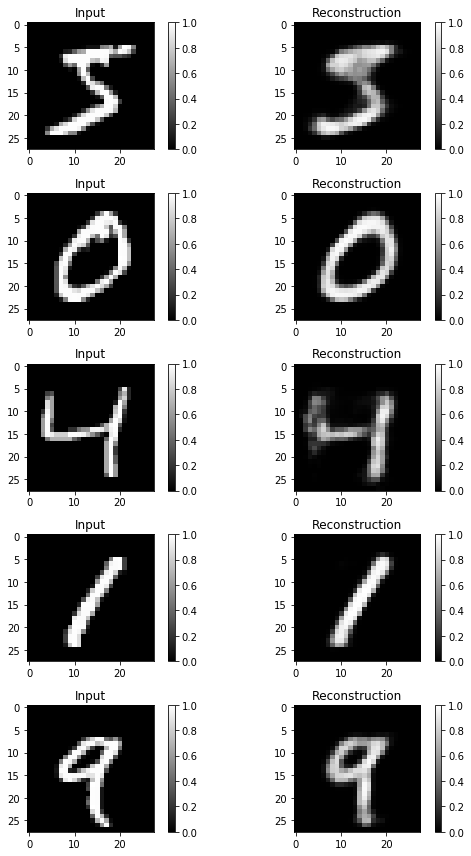

In [26]:
images = mnist.train_images()
x_sample = (images.reshape((60000, 784)) / 255)[:100,]
recon_x = vae.reconstruct(x_sample)

plt.figure(figsize=(8, 12))
for i in range(5):

    plt.subplot(5, 2, 2*i + 1)
    plt.imshow(x_sample[i].reshape(28, 28), vmin=0, vmax=1, cmap="gray")
    plt.title("Input")
    plt.colorbar()
    plt.subplot(5, 2, 2*i + 2)
    plt.imshow(recon_x[i].reshape(28, 28), vmin=0, vmax=1, cmap="gray")
    plt.title("Reconstruction")
    plt.colorbar()
    
plt.tight_layout()

#### Visualize Latent Separation

In [24]:
import tensorflow.compat.v1 as tf
tf.disable_eager_execution()

In [34]:
network_architecture = dict(n_hidden_enc_1=500, 
                             n_hidden_enc_2=500, 
                             n_hidden_dec_1=500, 
                             n_hidden_dec_2=500, 
                             n_input=784, 
                             n_z=2) 

vae_2d = train_mnist(network_architecture, n_epoch = 50)

Epoch: 1/50 Loss = 187.1168
Epoch: 2/50 Loss = 165.0954
Epoch: 3/50 Loss = 159.9970
Epoch: 4/50 Loss = 157.0830
Epoch: 5/50 Loss = 154.6968
Epoch: 6/50 Loss = 153.0162
Epoch: 7/50 Loss = 151.5064
Epoch: 8/50 Loss = 150.2746
Epoch: 9/50 Loss = 149.2687
Epoch: 10/50 Loss = 148.4417
Epoch: 11/50 Loss = 147.5988
Epoch: 12/50 Loss = 147.1841
Epoch: 13/50 Loss = 146.5540
Epoch: 14/50 Loss = 146.0747
Epoch: 15/50 Loss = 145.4335
Epoch: 16/50 Loss = 145.0870
Epoch: 17/50 Loss = 144.7869
Epoch: 18/50 Loss = 144.3838
Epoch: 19/50 Loss = 144.0387
Epoch: 20/50 Loss = 143.6779
Epoch: 21/50 Loss = 143.4421
Epoch: 22/50 Loss = 143.2087
Epoch: 23/50 Loss = 142.9368
Epoch: 24/50 Loss = 142.7892
Epoch: 25/50 Loss = 142.4564
Epoch: 26/50 Loss = 142.2984
Epoch: 27/50 Loss = 142.1635
Epoch: 28/50 Loss = 141.9748
Epoch: 29/50 Loss = 141.6336
Epoch: 30/50 Loss = 141.5280
Epoch: 31/50 Loss = 141.3247
Epoch: 32/50 Loss = 141.1663
Epoch: 33/50 Loss = 141.0522
Epoch: 34/50 Loss = 140.8188
Epoch: 35/50 Loss = 140

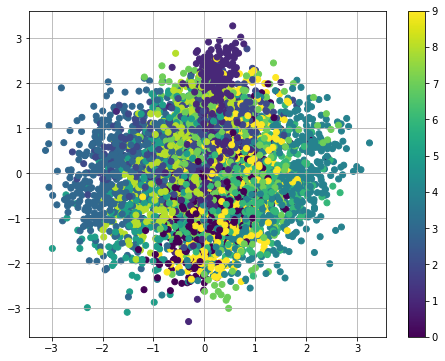

In [30]:
images = mnist.train_images()
labels = mnist.train_labels()
x_sample = (images.reshape((60000, 784)) / 255)[:5000,]
y_sample = labels[:5000]
z_mu = vae_2d.transform1d(x_sample)
plt.figure(figsize=(8, 6)) 
#plt.scatter(z_mu[:, 0], z_mu[:, 1], c=np.argmax(y_sample))
plt.scatter(z_mu[:, 0], z_mu[:, 1], c=y_sample)
#plt.scatter(z_mu[:, 0], z_mu[:, 1])
plt.colorbar()
plt.grid()

#### Visualize Latent Space

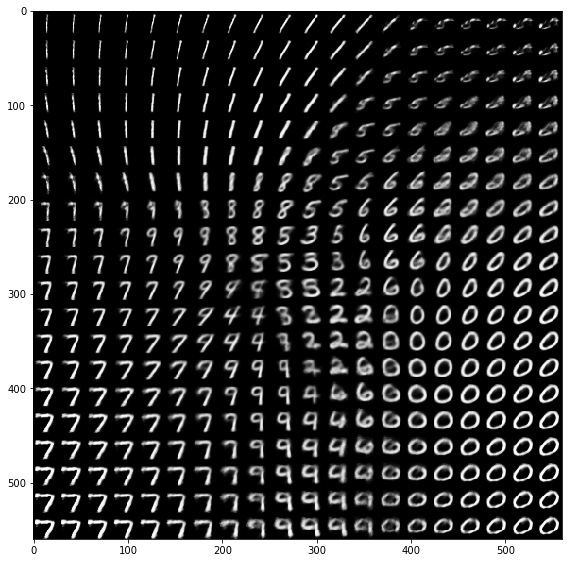

In [35]:
nx = ny = 20
x_values = np.linspace(-3, 3, nx)
y_values = np.linspace(-3, 3, ny)

canvas = np.empty((28*ny, 28*nx))
for i, yi in enumerate(x_values):
    for j, xi in enumerate(y_values):
        z_mu = np.array([[xi, yi]]*vae.batch_size)
        x_mean = vae_2d.generate(z_mu)
        canvas[(nx-i-1)*28:(nx-i)*28, j*28:(j+1)*28] = x_mean[0].reshape(28, 28)

plt.figure(figsize=(8, 10))        
Xi, Yi = np.meshgrid(x_values, y_values)
plt.imshow(canvas, origin="upper", cmap="gray")
plt.tight_layout()

In [42]:
import matplotlib as mpl
from mpl_toolkits.axes_grid1 import Grid

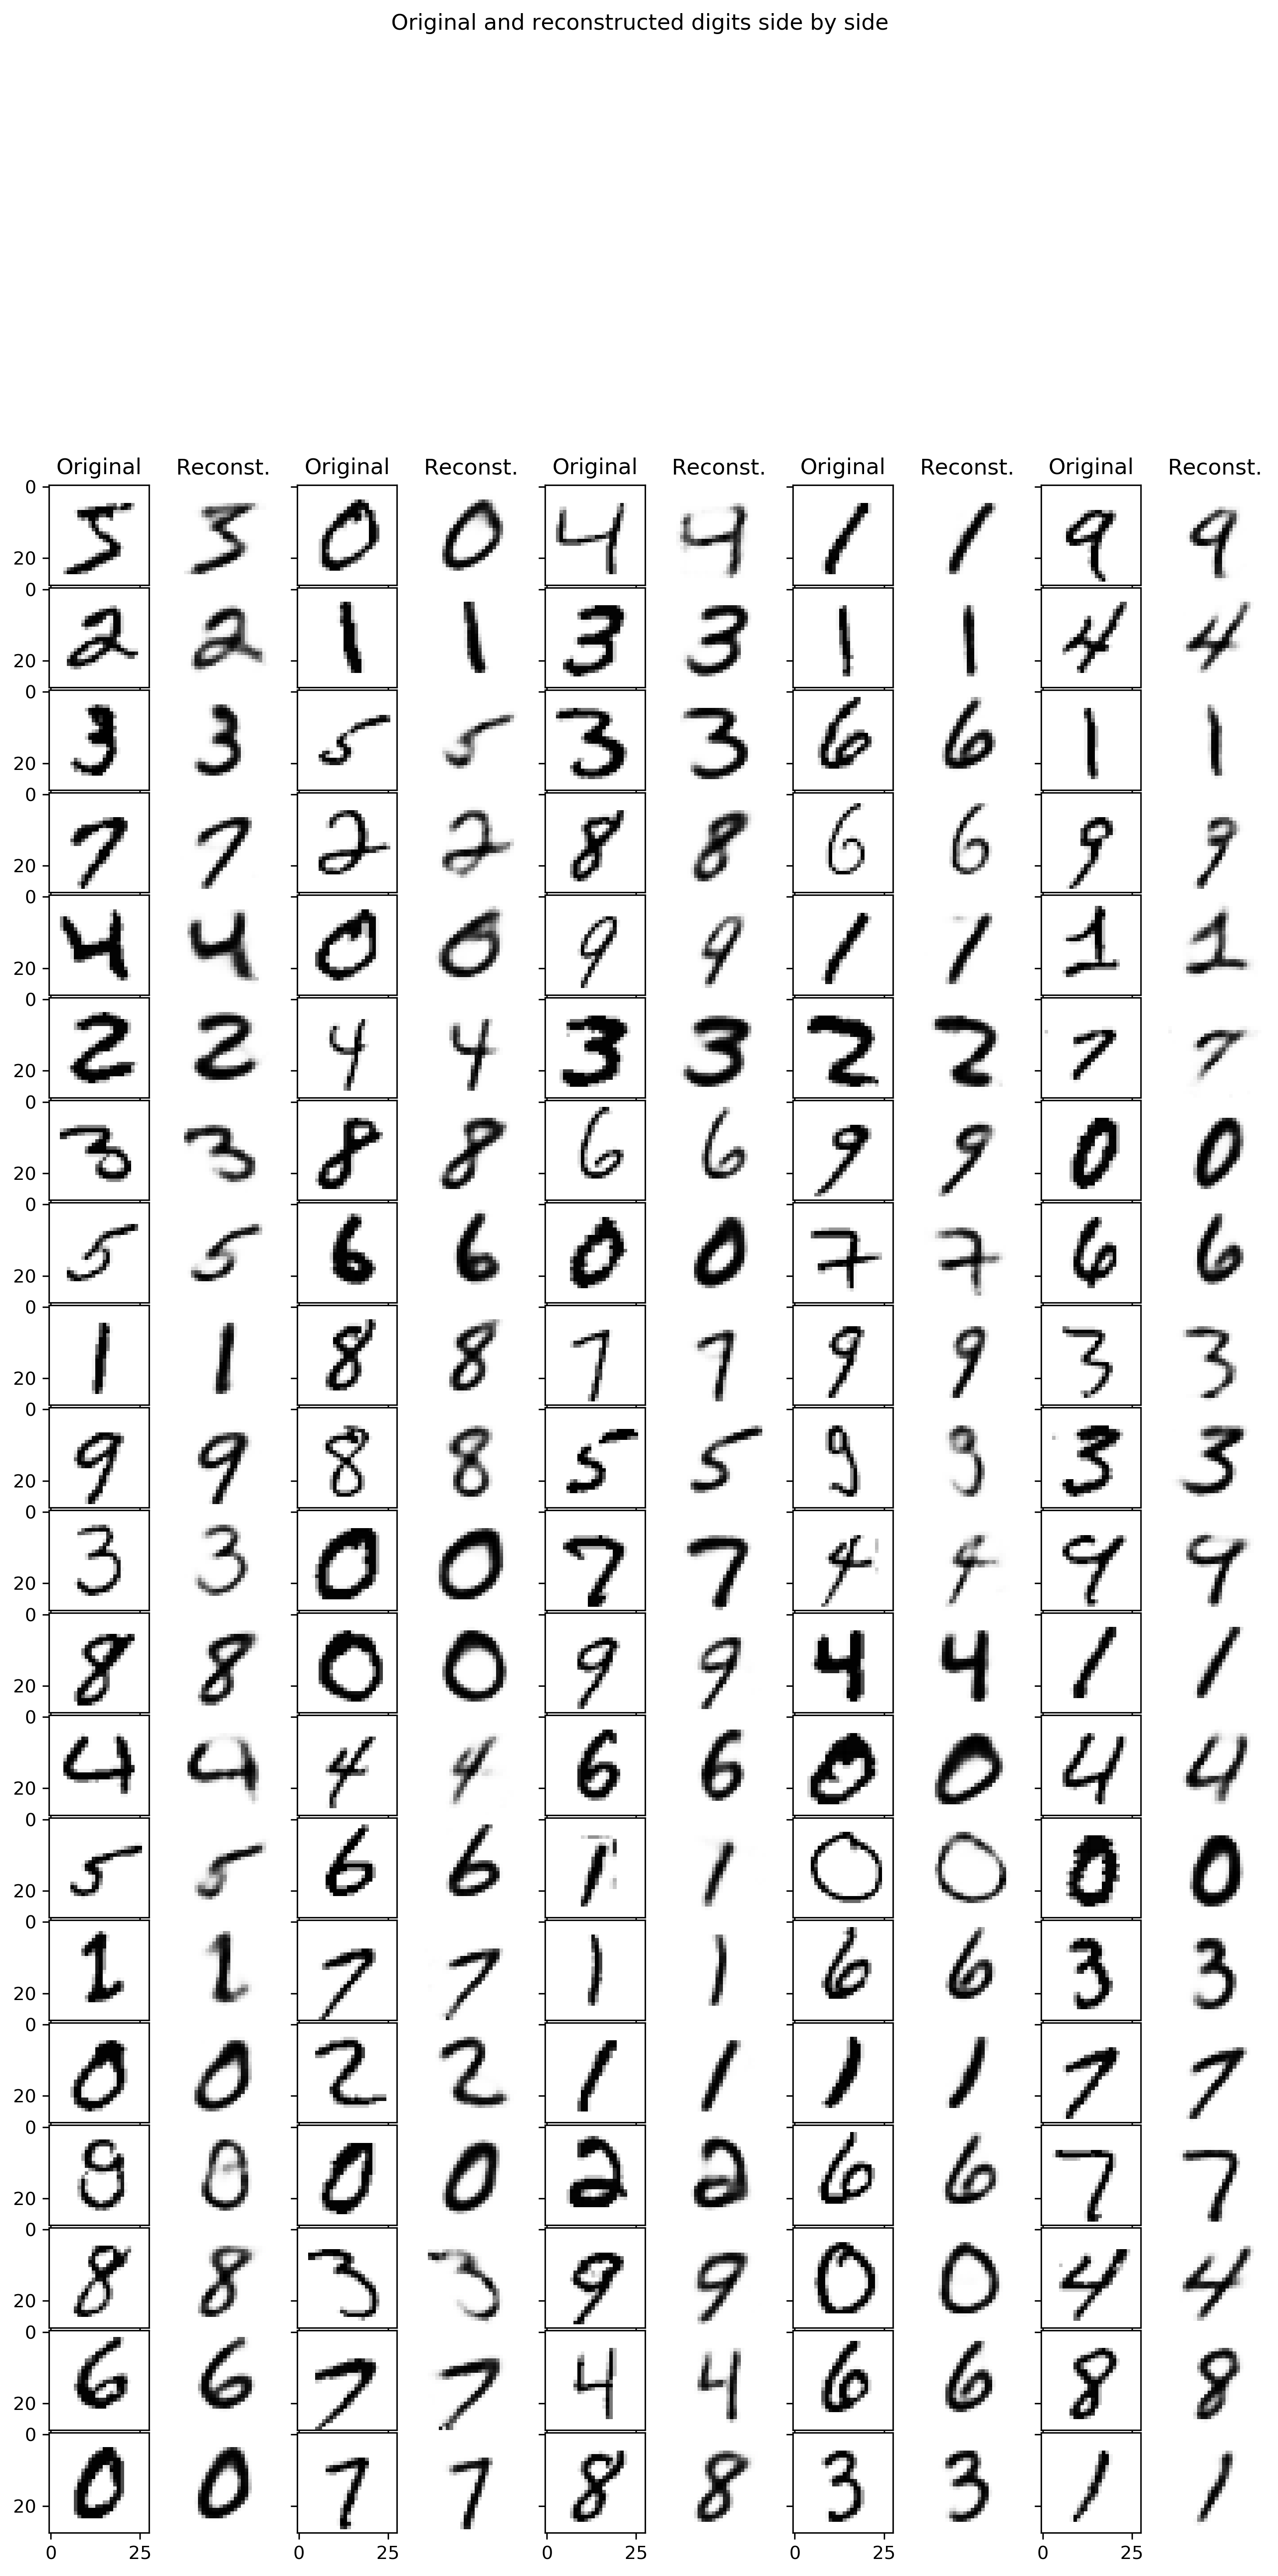

<Figure size 432x288 with 0 Axes>

In [49]:
images = mnist.train_images()
x_sample = (images.reshape((60000, 784)) / 255)[:100,]
recon_x = vae.reconstruct(x_sample)

ncols = 10
n = 100
nrows = int(n/5)
fig = plt.figure(figsize=(ncols, nrows), dpi=300)
grid = Grid(fig, rect=111, nrows_ncols=(nrows,10))

for i, ax in enumerate(grid):
    j = i//2
    if i%2 == 0:
        ax.imshow(x_sample[j,].reshape(28,28), cmap=mpl.cm.Greys)
        if i<ncols:
            ax.set_title("Original")
    else:
        ax.imshow(recon_x[j,].reshape(28,28), cmap=mpl.cm.Greys)
        if i<ncols:
            ax.set_title("Reconst.")

        ax.set_axis_off()

fig.suptitle('Original and reconstructed digits side by side')
fig.tight_layout()
fig.subplots_adjust(top=0.80)    
plt.show()
plt.savefig('Recon_images.png')

### Evaluation Metrics
Consider metrics for generative models: reconstruction error, marginal log-likelihood (negative ELBO).

In [50]:
def BCE(x, y):
    """
    Calculate binary cross entropy loss for reconstruction loss in the ELBO.
    """

    loss = np.sum(-y * np.log(x + 10e-8) - (1 - y) * np.log(1 - x + 10e-8))

    return loss

In [94]:
images = mnist.train_images()
x_sample = (images.reshape((60000, 784)) / 255)[:1000,]
recon_x = vae.reconstruct(x_sample)

In [51]:
def evaluate(X, recon_X):
        """
        Evaluate the accuracy of the model with reconstruction error and marginal log-likelihood.
        """
        rec_loss = BCE(recon_X, X) / len(X)
        # Marginal log-likelihood of data = - ELBO
        marg_likelihood = - vae.train(X)
        
        return rec_loss, marg_likelihood

In [96]:
evaluate(x_sample, recon_x)

(106.49117566196126, -124.59328)

### Comparative Analysis
Compared to 2 image reconstruction algorithms for MNIST data set:
    - RBM: https://www.kaggle.com/nicw102168/restricted-boltzmann-machine-rbm-on-mnist/notebook
    - DBN: https://github.com/2015xli/DBN

#### Restricted Boltzman Machine (RBM)

In [174]:
plt.rcParams['image.cmap'] = 'gray'
import pandas as pd

In [175]:
def gen_mnist_image(X):
    return np.rollaxis(np.rollaxis(X[0:200].reshape(20, -1, 28, 28), 0, 2), 1, 3).reshape(-1, 20 * 28)

In [181]:
X_train = pd.read_csv('./vae/data/train.csv').values[:,1:]
X_train = (X_train - np.min(X_train, 0)) / (np.max(X_train, 0) + 0.0001)

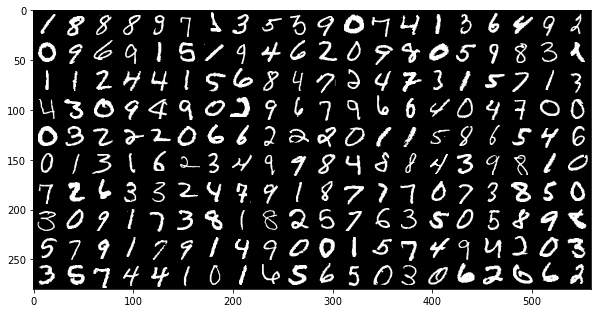

In [182]:
plt.figure(figsize=(10,20))
plt.imshow(gen_mnist_image(X_train));

In [183]:
from sklearn.neural_network import BernoulliRBM
rbm = BernoulliRBM(n_components=100, learning_rate=0.01, random_state=0, verbose=True)
rbm.fit(X_train)

[BernoulliRBM] Iteration 1, pseudo-likelihood = -119.88, time = 7.51s
[BernoulliRBM] Iteration 2, pseudo-likelihood = -104.69, time = 7.99s
[BernoulliRBM] Iteration 3, pseudo-likelihood = -97.89, time = 7.03s
[BernoulliRBM] Iteration 4, pseudo-likelihood = -93.07, time = 6.78s
[BernoulliRBM] Iteration 5, pseudo-likelihood = -91.11, time = 6.86s
[BernoulliRBM] Iteration 6, pseudo-likelihood = -88.89, time = 6.97s
[BernoulliRBM] Iteration 7, pseudo-likelihood = -86.87, time = 7.07s
[BernoulliRBM] Iteration 8, pseudo-likelihood = -84.41, time = 7.18s
[BernoulliRBM] Iteration 9, pseudo-likelihood = -84.58, time = 10.42s
[BernoulliRBM] Iteration 10, pseudo-likelihood = -83.33, time = 8.27s


BernoulliRBM(batch_size=10, learning_rate=0.01, n_components=100, n_iter=10,
             random_state=0, verbose=True)

In [184]:
xx = X_train[:40].copy()
for ii in range(1000):
    for n in range(40):
        xx[n] = rbm.gibbs(xx[n])

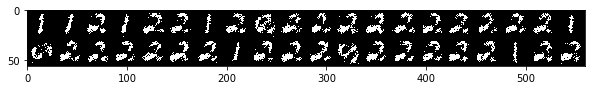

In [185]:
plt.figure(figsize=(10,20))
plt.imshow(gen_mnist_image(xx))

#### Deep Belief Networks (DBN)
See '.DBN/DBN.ipynb' demo

### Applications to Brain Connectomes Data

In [213]:
from scipy.io import loadmat
from sklearn.preprocessing import normalize

In [211]:
dat_mat = loadmat('./vae/data/HCP_subcortical_CMData_desikan.mat')
tensor = dat_mat['loaded_tensor_sub']
network_ids = dat_mat['all_id'].reshape(-1)

In [215]:
#offset = 100 

net_data = []
for i in range(tensor.shape[3]):
    ith = np.float32(tensor[:,:,0,i] + np.transpose(tensor[:,:,0,i])) # [:,:,0,:] - network data
    #ith = ith/offset
    ith = ith[18:86, 18:86]
    ith = ith.flatten()
    net_data.append(ith)

In [218]:
brain_graphs = np.stack(net_data)
brain_graphs = normalize(brain_graphs) # Normalize data
print(brain_graphs.shape)

(1065, 4624)


In [230]:
def train_brain_graphs(network_architecture, 
                    learning_rate=0.001, batch_size=6, n_epoch=10):
    """
    Train the VAE model on the Brain Connectomes data set.
    """
    
    vae = VAE(network_architecture, learning_rate=learning_rate, batch_size=batch_size)
    
    train_data = brain_graphs 
    train_size = train_data.shape[0]
    
    for epoch in range(n_epoch):
        
        avg_loss = 0.
        n_batch = int(train_size / batch_size) 

        for idx in range(n_batch):
            train_batch = train_data[idx * batch_size:idx * batch_size + batch_size]
            loss = vae.train(train_batch)
            avg_loss += loss / train_size * batch_size

        print("Epoch:", "%d/%d" % (epoch+1, n_epoch), 
              "Loss =", "{:.4f}".format(avg_loss))
        
    return vae

In [231]:
network_architecture = dict(n_hidden_enc_1 = 1000, 
                             n_hidden_enc_2 = 500, 
                             n_hidden_dec_1 = 500, 
                             n_hidden_dec_2 = 1000, 
                             n_input = 68 * 68, 
                             n_z = 100)  

vae = train_brain_graphs(network_architecture, n_epoch = 20)

/Users/yizizhang/anaconda3/lib/python3.6/site-packages/tensorflow/python/client/session.py:1714: UserWarning: An interactive session is already active. This can cause out-of-memory errors in some cases. You must explicitly call `InteractiveSession.close()` to release resources held by the other session(s).


Epoch: 1/20 Loss = 187.0026
Epoch: 2/20 Loss = 95.3625
Epoch: 3/20 Loss = 95.4436
Epoch: 4/20 Loss = 95.4670
Epoch: 5/20 Loss = 95.4857
Epoch: 6/20 Loss = 95.4555
Epoch: 7/20 Loss = 95.5095
Epoch: 8/20 Loss = 95.5094
Epoch: 9/20 Loss = 95.3700
Epoch: 10/20 Loss = 95.5363
Epoch: 11/20 Loss = 95.4132
Epoch: 12/20 Loss = 95.4689
Epoch: 13/20 Loss = 95.4388
Epoch: 14/20 Loss = 95.4079
Epoch: 15/20 Loss = 95.2921
Epoch: 16/20 Loss = 95.1964
Epoch: 17/20 Loss = 95.2771
Epoch: 18/20 Loss = 95.2557
Epoch: 19/20 Loss = 95.4037
Epoch: 20/20 Loss = 95.4080


In [250]:
x_sample = brain_graphs[:6,] * 1e4 # multiply by 1e4 to visualize the graphs
recon_x = vae.reconstruct(brain_graphs[:6,]) * 1e4

#### Plot
- First row is the original brain graphs. 
- Second row is the re-constructed brain graphs.

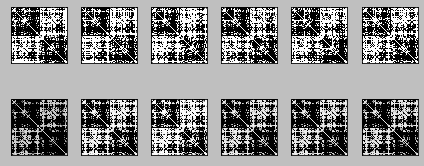

In [251]:
n_plot_samps = 6
IMG_DIM = 68

from src.plot_tools import pics_tools as pic
import matplotlib.pyplot as plt
plt.style.use('grayscale')

fig = pic.plot_image_grid( \
  1-np.concatenate([x_sample[:n_plot_samps], recon_x], axis=0),
  [IMG_DIM, IMG_DIM], \
  (2, n_plot_samps) \
)
plt.tight_layout()
plt.show()